In [28]:
import pandas as pd
import numpy as np
from numpy import mean
from numpy import std
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
pd.options.display.float_format = '{:.2f}'.format
import pandas_profiling as pp  
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split, GridSearchCV


In [29]:
#carregamento dos dados
df_card = pd.read_csv('card_transdata.csv')

In [30]:
df_card.head()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,57.88,0.31,1.95,1.00,1.00,0.00,0.00,0.00
1,10.83,0.18,1.29,1.00,0.00,0.00,0.00,0.00
2,5.09,0.81,0.43,1.00,0.00,0.00,1.00,0.00
3,2.25,5.60,0.36,1.00,1.00,0.00,1.00,0.00
4,44.19,0.57,2.22,1.00,1.00,0.00,1.00,0.00


In [31]:
df_card.describe()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
count,1000000.00,1000000.00,1000000.00,1000000.00,1000000.00,1000000.00,1000000.00,1000000.00
mean,26.63,5.04,1.82,0.88,0.35,0.10,0.65,0.09
std,65.39,25.84,2.80,0.32,0.48,0.30,0.48,0.28
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,3.88,0.30,0.48,1.00,0.00,0.00,0.00,0.00
50%,9.97,1.00,1.00,1.00,0.00,0.00,1.00,0.00
75%,25.74,3.36,2.10,1.00,1.00,0.00,1.00,0.00
max,10632.72,11851.10,267.80,1.00,1.00,1.00,1.00,1.00


In [32]:
df_card.isnull().sum()

distance_from_home                0
distance_from_last_transaction    0
ratio_to_median_purchase_price    0
repeat_retailer                   0
used_chip                         0
used_pin_number                   0
online_order                      0
fraud                             0
dtype: int64

In [33]:
print(df_card.dtypes)

distance_from_home                float64
distance_from_last_transaction    float64
ratio_to_median_purchase_price    float64
repeat_retailer                   float64
used_chip                         float64
used_pin_number                   float64
online_order                      float64
fraud                             float64
dtype: object


In [34]:
profile = pp.ProfileReport(df_card)
profile.to_file('output.html')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [35]:
df_card.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
 #   Column                          Non-Null Count    Dtype  
---  ------                          --------------    -----  
 0   distance_from_home              1000000 non-null  float64
 1   distance_from_last_transaction  1000000 non-null  float64
 2   ratio_to_median_purchase_price  1000000 non-null  float64
 3   repeat_retailer                 1000000 non-null  float64
 4   used_chip                       1000000 non-null  float64
 5   used_pin_number                 1000000 non-null  float64
 6   online_order                    1000000 non-null  float64
 7   fraud                           1000000 non-null  float64
dtypes: float64(8)
memory usage: 61.0 MB


In [36]:

df1 = df_card.copy(deep = True) 


In [37]:
len(df1[df1['fraud']==1.0]), len(df1[df1['fraud']==0.0])

(87403, 912597)

In [38]:
# nivelamento entre a quantidade de amostras de fraude e de compras sem fraude
from imblearn.under_sampling import RandomUnderSampler
undersample = RandomUnderSampler(sampling_strategy=0.7)
feature_columns = list(df1.columns.drop('fraud'))
X = df1[feature_columns]
Y = df1['fraud']
X_balanced, Y_balanced = undersample.fit_resample(X, Y)
df1 = X_balanced
df1['fraud'] = Y_balanced

In [39]:
len(df1[df1['fraud']==1.0]), len(df1[df1['fraud']==0.0])

(87403, 124861)

In [40]:
#padronização dos dados contínuos
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
df1['distance_from_home'] = ss.fit_transform(df1[['distance_from_home']])
df1['distance_from_last_transaction'] = ss.fit_transform(df1[['distance_from_last_transaction']])
df1['ratio_to_median_purchase_price'] = ss.fit_transform(df1[['ratio_to_median_purchase_price']])

<Axes: >

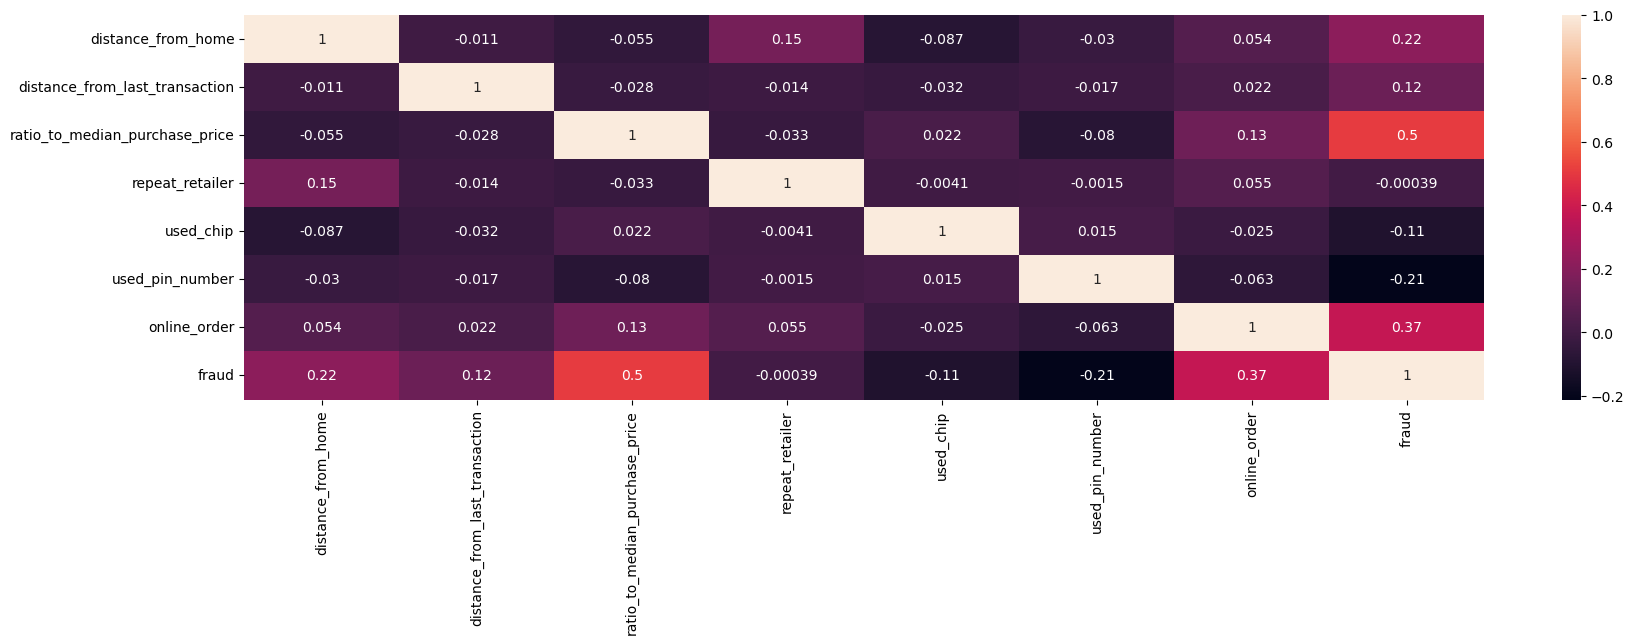

In [41]:
plt.figure(figsize=(20,5))
sns.heatmap(df1.corr(), annot=True)

In [42]:
categorical_features = ['used_pin_number', 'used_chip', 'online_order', 'repeat_retailer', 'fraud']
numeric_features = ['distance_from_home', 'distance_from_last_transaction', 'ratio_to_median_purchase_price']


In [43]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

<Axes: >

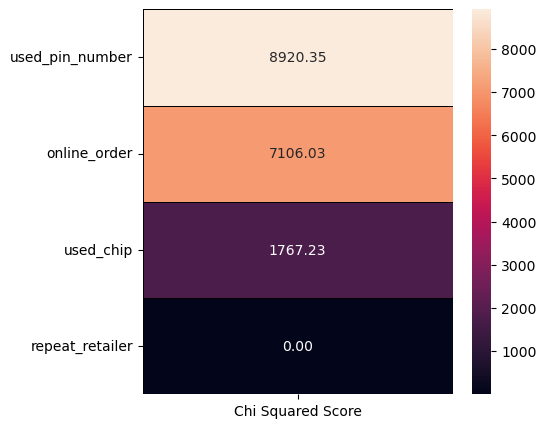

In [44]:
# classificação da relevância das variáveis categóricas com teste chi quadrado
features = df1.loc[:,categorical_features[:-1]]
target = df1['fraud']
best_features = SelectKBest(score_func= chi2, k= 'all')
fit = best_features.fit(features, target)
featuresScores = pd.DataFrame(data = fit.scores_, index= list(features.columns), columns=['Chi Squared Score'])

plt.subplots(figsize = (5,5))
sns.heatmap(featuresScores.sort_values(ascending=False, by='Chi Squared Score'), annot=True, linewidths=0.6, linecolor='black', fmt='.2f')


Text(0.5, 1.0, 'Seleção variáveis numéricas')

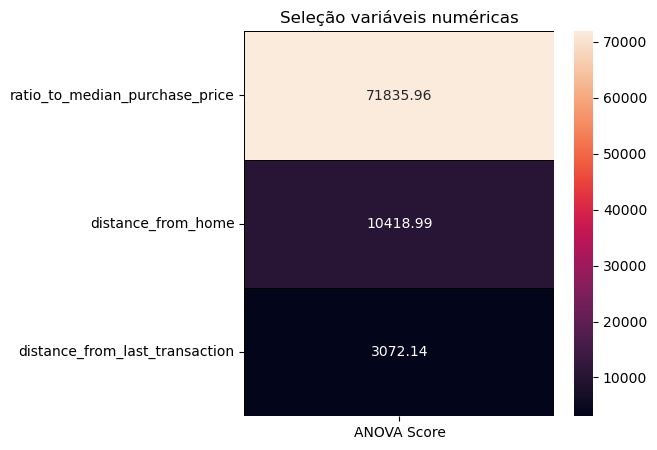

In [45]:
# classificação da relevância das variáveis quantitativas contínuas com teste F
from sklearn.feature_selection import f_classif
features_n = df1.loc[:, numeric_features]
target = df1['fraud']
best_features_n = SelectKBest(score_func=f_classif, k='all')
fit = best_features_n.fit(features_n, target)
featuresScores_n = pd.DataFrame(data = fit.scores_, index= list(features_n.columns), columns=['ANOVA Score'])

plt.subplots(figsize = (5,5))
sns.heatmap(featuresScores_n.sort_values(ascending=False, by='ANOVA Score'), annot=True, linewidths=0.6, linecolor='black', fmt='.2f')
plt.title('Seleção variáveis numéricas')

In [46]:
# retirada das variáveis 'repeat_retailer' do treinamento por serem menos relevantes conforme teste chi quadrado
# definindo dados atributos e alvos e separando em treino e teste
features = df1[df1.columns.drop(['fraud', 'repeat_retailer'])].values
target = df1['fraud'].values
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.20, random_state=42)

In [47]:
from sklearn.model_selection import cross_val_score

In [48]:
xgb = XGBClassifier(learning_rate = 0.02, objective='binary:logistic', nthread = 4)

In [49]:
resultado_cv = cross_val_score(xgb, x_train, y_train).mean()

In [50]:
resultado_cv

0.9998409998036797

In [51]:
xgb.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.02, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, nthread=4, num_parallel_tree=None,
              predictor=None, ...)

In [52]:
predict = xgb.predict(x_test)

In [53]:
print("Quantidade de predições corretas: {}, quantidade de predicões incorrentas: {}".format((predict == y_test).sum(), (predict != y_test).sum()))

Quantidade de predições corretas: 42442, quantidade de predicões incorrentas: 11


In [54]:
xgb_params = {
    'n_estimators': [250],
    'max_depth': [5],
    'subsample': [0.6, 0.8]
}

In [55]:
gs_xgb = GridSearchCV (
    estimator= xgb,
    param_grid = xgb_params,
    cv = 2,
    scoring= 'roc_auc',
    refit= True,
    verbose= 1
)

In [56]:
gs_xgb.fit(x_train, y_train)

Fitting 2 folds for each of 2 candidates, totalling 4 fits


GridSearchCV(cv=2,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=0.02, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None, nthread=4,
                                     num_parallel_tree=None, predictor=None, ...),
             param_grid={'max_depth': [5], 'n_estimators': [250],
                         'subsample': [0.6, 0.8]},
             scoring='roc_auc', verbose=1)

In [57]:
gs_xgb.best_score_

0.9999949787089937

In [58]:
gs_xgb.best_params_

{'max_depth': 5, 'n_estimators': 250, 'subsample': 0.6}

In [59]:
predict1 = gs_xgb.predict(x_test)

In [60]:
print("Quantidade de predições corretas: {}, quantidade de predicões incorrentas: {}".format((predict1 == y_test).sum(), (predict1 != y_test).sum()))

Quantidade de predições corretas: 42446, quantidade de predicões incorrentas: 7


In [61]:
y_probs = xgb.predict_proba(x_test)[:,1]

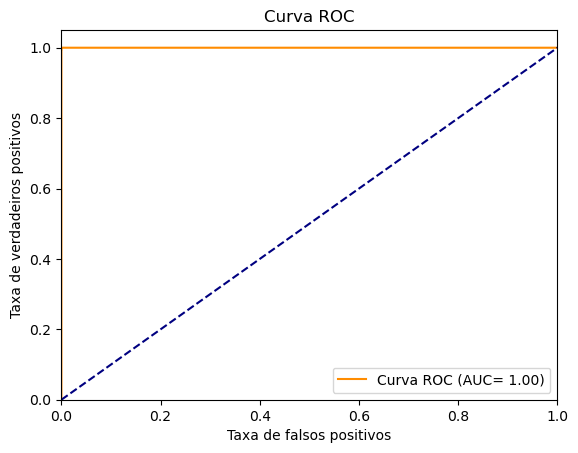

In [62]:
#gráfico ROC
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', label = 'Curva ROC (AUC= %0.2f)'%roc_auc)
plt.plot([0,1], [0,1], color='navy', linestyle ='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de falsos positivos')
plt.ylabel('Taxa de verdadeiros positivos')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.show()
